In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import math 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from scipy.stats import kurtosis, skew

In [5]:
path = "C:/Users/HP/Desktop/Data Science/Data/oil_exxon.xlsx"
price_data = pd.read_excel(path)

# set the index equal to the date column & then drop the old date column
price_data.index = pd.to_datetime(price_data['date'])
price_data = price_data.drop(['date'], axis = 1)

# print the first five rows
price_data.head()

,exon_price,oil_price
date,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


### Step Three: Clean the data

The chances of getting a perfectly cleaned dataset that meets all of the requirements is slim to none, so to make this tutorial more realistic we will clean the data. Here is the checklist when it comes to cleaning the data:

1.Check the data types, to make sure they are correct. For example, it usually does not make sense for a number to be a string.

2.Make sure the column names are correct. Having the correct column names makes the process of selecting data easier.

3.Check for and drop/fill missing values. Dropping errors helps to control for errors when running.

In [6]:
# check the data types, in this case everything looks fine no changes need to be made.
price_data.dtypes

exon_price    float64
oil_price     float64
dtype: object

While looking at the data, we can see one of the columns is misspelled, so let us fix that by creating a dictionary object where the old name is the key, and the new name is the value for that key. Once we do that, we can call the rename() method on the DataFrame and pass through the new_column_names dictionary through the columns parameter.

In [7]:
# define the new name.
new_column_names = {'exon_price':'exxon_price'}

# rename the column
price_data = price_data.rename(columns = new_column_names)
price_data.head()

,exxon_price,oil_price
date,,
2014-03-28,97.699997,106.64
2014-03-31,97.680000,105.95
2014-04-01,97.730003,105.70
2014-04-02,97.949997,103.37
2014-04-03,97.930000,104.88


Missing values, they can be a problem because they can create errors when running calcs. The first thing is we should always check to see if there are any missing values. If we use the .isna().any() method on the DataFrame it will return each column with a boolean, where True means it has missing values and False means it does not have any missing values. Once, we know the data has missing values we can use the dropna() method to drop any rows that have a missing value.

In [8]:
# check for missing values
display(price_data.isna().any())

# drop any missing values
price_data = price_data.dropna()

# let's check to make sure they've all been removed.
price_data.isna().any()

exxon_price    False
oil_price       True
dtype: bool

exxon_price    False
oil_price      False
dtype: bool

In [10]:
price_data.shape

(1248, 2)

### Section Four: Explore the Data
Okay, now that we have a clean dataset let us explore it a little. Again, this is a critical step as it helps us understand some of the following questions:

1.How is the data distributed?
2. Does there appear to be a relationship between the two variables?
3.Are there any outliers?
4. Is the data skewed?

By better understanding the answers to these questions we can validate whether we need to do further transformations or if we need to change the model we picked.

### Build a Scatter Plot
Scatter plots help us visualize the relationship between our data, so let us plot our data using the graph so we can explore the relationship. We need to define the x-coordinate and the y-coordinate, and then plot them using the plot() method. Now, we did a few formatting steps, so our graph comes out logically.

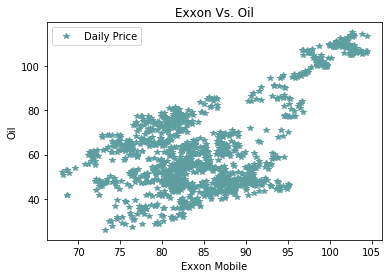

In [23]:
# define the x & y data.
x = price_data['exxon_price']
y = price_data['oil_price']

# create the scatter plot.
plt.plot(x, y, '*', color ='cadetblue', label = 'Daily Price')

# make sure it's formatted.
plt.title("Exxon Vs. Oil")
plt.xlabel("Exxon Mobile")
plt.ylabel("Oil")
plt.legend()

plt.show()

### Measure the Correlation
At first glance, we can tell there is some relationship here because they seem to be moving in tandem. The relationship means if one goes up the other appears to go up as well and also tells us it appears to be a positive relationship because they both move up. However, if we would like to attach a number to this relationship so we can quantify it. Well, in this case, let us measure the correlation between the two variables. We will take the DataFrame and call the corr() method to return a DataFrame with the metrics.

In [12]:
# let's measure that correlation
price_data.corr()

,exxon_price,oil_price
exxon_price,1.00000,0.60132
oil_price,0.60132,1.00000


Okay, so there is a correlation and a strong one at that. Generally speaking, this is how we measure the strength of correlations.

Very strong relationship (|r|>0.8 =>)

Strong relationship (0.6≤|r|)

Moderate relationship (0.4≤|r|)

Weak relationship (0.2≤|r|)

Very weak relationship (|r|)


In [13]:

# let's take a look at a statistical summary.
price_data.describe()

,exxon_price,oil_price
count,1248.000000,1248.000000
mean,84.802796,61.935000
std,7.424687,19.288424
min,68.120003,26.010000
25%,80.190002,48.162500
50%,83.024998,57.120000
75%,88.529999,70.725000
max,104.379997,115.190000


Nothing stands out as a concern at this point, our range is healthy, and all the data falls within 3 Standard deviations of the mean. In other words, we do not seem to have any outliers that we need to worry with. They both have the same count so we look good there and we get a good idea of the min and max. Overall, we should be happy with the output.

### Checking for Outliers and Skewness

We do not want outliers, and we want to make sure our data does not have skew because this could impact results in specific models. The first thing we will do is a plot a histogram for each column of data. The data will help us get a good idea of the distribution. Once, we have done that we will do some hard measurements to validate our visuals.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015C6B719CC8>,
      dtype=object)

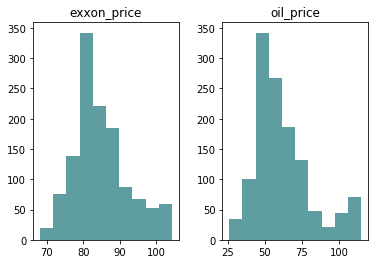

In [14]:
price_data.hist(grid = False, color = 'cadetblue')

Okay, so some of the data does appear to be skewed but not too much. However, we probably should verify this by taking some measurements. Two good metrics we can use are the kurtosis and skew, where kurtosis measure the height of our distribution and skew measures whether it is positively or negatively skewed. We will use the scipy.stats module to do the measurements.

In [15]:
# calculate the excess kurtosis using the fisher method. The alternative is Pearson which calculates regular kurtosis.
exxon_kurtosis = kurtosis(price_data['exxon_price'], fisher = True)
oil_kurtosis = kurtosis(price_data['oil_price'], fisher = True)

# calculate the skewness
exxon_skew = skew(price_data['exxon_price'])
oil_skew = skew(price_data['oil_price'])

display("Exxon Excess Kurtosis: {:.2}".format(exxon_kurtosis))  # this looks fine
display("Oil Excess Kurtosis: {:.2}".format(oil_kurtosis))      # this looks fine

display("Exxon Skew: {:.2}".format(exxon_skew))          # moderately skewed
display("Oil Skew: {:.2}".format(oil_skew))              # moderately skewed, it's a little high but we will accept it.

'Exxon Excess Kurtosis: 0.088'

'Oil Excess Kurtosis: 0.53'

'Exxon Skew: 0.66'

'Oil Skew: 1.0'

In [16]:
# perform a kurtosis test
display('Exxon')
display(stats.kurtosistest(price_data['exxon_price']))
display('Oil')
display(stats.kurtosistest(price_data['oil_price']))

# perform a skew test
display('Exxon')
display(stats.skewtest(price_data['exxon_price']))
display('Oil')
display(stats.skewtest(price_data['oil_price']))

#  for p-value check e- value  
# For 3 cases we reject the null hypothesis of Normal distribution that the kurtosis of the population from which the 
# sample was drawn is that of the normal distribution:

'Exxon'

KurtosistestResult(statistic=0.7185349375030217, pvalue=0.47242751383320714)

'Oil'

KurtosistestResult(statistic=3.193868719980946, pvalue=0.0014037993965471192)

'Exxon'

SkewtestResult(statistic=8.770169400598549, pvalue=1.7839768456341654e-18)

'Oil'

SkewtestResult(statistic=12.471137868018896, pvalue=1.0728306198159923e-35)

We can also perform a kurtosistest() and skewtest() on our data to test whether the data is normally distributed. With these two functions we test the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1) & the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution, respectively.

However, there is a big caveat to this. As our dataset grows larger, the chances of us rejecting the null hypothesis increases even if there is only slight kurtosis or skew. In other words, even if our dataset is slightly non-normal, we will reject the null hypothesis. These results are unrealistic because the chances of us having a perfectly normal dataset are very very slim, so we have to take these results with a grain of salt.

### Kurtosis

Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic. This is a normal distribution

Any distribution with kurtosis <3 (excess kurtosis <0) is called platykurtic. Tails are shorter and thinner, and often its central peak is lower and broader.

Any distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic. Tails are longer and fatter, and often its central peak is higher and sharper.

### Skewness

If skewness is less than −1 or greater than +1, the distribution is highly skewed.

If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.

If skewness is between −½ and +½, the distribution is approximately symmetric

### Section Five: Build the Model

At this point, we feel comfortable moving forward other than the data being slightly skewed nothing else is stopping us from going with the linear regression model.



### Split the Data
The first thing we need to do is split the data into a training set and a test set. The training set is what we will train the model on and the test set is what we will test it on. The convention is to have 20% dedicated to testing and the remaining 80% to training, but these are not hard limits.

In [17]:
# define our input variable (X) & output variable.
Y = price_data.drop('oil_price', axis = 1)
X = price_data[['oil_price']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

### Create & Fit the model
Making the model surprises many people of how easy this step is. All we do is create an instance of the linear regression model from Sklearn and then call the fit() method to train the model on our training data.

In [19]:
# create a Linear Regression model object.
regression_model = LinearRegression()

# pass through the X_train & y_train data set.
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Explore the output
Let us see what got sent back to us. First, we can check the coefficient of each independent variable in our model. In this case, it is just the oil price. After that let us take a look at the intercept of our regression formula.

In [22]:
# let's grab the coefficient of our model and the intercept. [0] -returns an array
# [0][0]- nested list
intercept = regression_model.intercept_[0]
coefficient = regression_model.coef_[0][0]

print("The Coefficient for our model is {:.2}".format(coefficient))
print("The intercept for our model is {:.4}".format(intercept))

The Coefficient for our model is 0.24
The intercept for our model is 70.01


Interpreting the coefficient, we would say that a single unit increase in oil is associated with a 0.24 increase in the price of Exxon Mobile stock. We are NOT CLAIMING CAUSATION, just association.

## Taking a Single Prediction

Now that we understand what the model looks like and how to interpret the output let us make some predictions. If we want we can make a single prediction by passing through a price in a list of list. Once we have an output, we slice it to get the value.

In [21]:
# let's test a prediction
prediction = regression_model.predict([[67.33]])
predicted_value = prediction[0][0]
print("The predicted value is {:.4}".format(predicted_value))

The predicted value is 85.95


###  Making Multiple Predictions at Once
Great, so we have a good working model let us test it on the data we set aside. We will call the predict() method and pass through our X_test dataset at which point a list of predictions will be returned to us.

In [24]:
# Get multiple predictions.
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[82.23530265],
       [82.87451035],
       [81.48245802],
       [78.9256272 ],
       [84.01324704]])

## Section Six: Evaluating the Model
Once we have a functioning model that we can use to make predictions we need to evaluate how useful our model is. There is no sense of using a model that makes horrible predictions, so we should look at different metrics to see how it did.

Now to make this process easier on ourselves, we are going to recreate our same model using the statsmodel.api library. The reason why is that they have numerous built-in functions that make calculating metrics like confidence intervals and p-values a breeze. The output from the statsmodel.api will not be identical to our sklearn library but it will be very close.

In [25]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model.
model = sm.OLS(Y, X2)

# fit the data
est = model.fit()

### Confidence Intervals
First, let us calculate confidence intervals. Keep in mind that by default that the calculated using 95% intervals. We interpret this by saying if the population from which this sample was drawn was sampled 100 times. Approximately 95 of those confidence intervals would contain the "true" coefficient.

Why do we provide a confidence range? Well, it comes from the fact that we only have a sample of the population, not the entire population itself. Because of this concept, means that the "true" coefficient could exist in the interval below or it couldn't, but we cannot say for sure. We provide some uncertainty by providing a range, usually 95% interval, where the coefficient is probably in.

In [26]:
# make some confidence intervals, 95% by default.
est.conf_int()

,0,1
const,69.358126,71.57579
oil_price,0.214372,0.24856


Interpreting the output above, we would say that with 95% confidence the oil_price coefficient exists between 0.214 & 0.248.

Want a narrower range? Decrease your confidence.
Want a wider range? Increase your confidence.

### Hypothesis Testing

### Null Hypothesis: There is no relationship between the price of oil and the price of Exxon.
The coefficient equals 0.

### Alternative Hypothesis: There is a relationship between the price of oil and the price of Exxon.

The coefficient does not equal to 0.
If we reject the null, we are saying there is a relationship, and the coefficient does not equal 0.

If we fail to reject the null, we are saying there is no relationship, and the coefficient does equal 0.

In [27]:
# estimate the p-values.
est.pvalues

const         0.000000e+00
oil_price    1.423529e-123
dtype: float64

The p-value represents the probability that the coefficient equals 0. We want a p-value that is less than 0.05 if it is we can reject the null hypothesis. In this case, the p-value for the oil_price coefficient is much lower than 0.05, so we can reject the null hypothesis and say that there is a relationship and that we believe it to be between oil and the price of Exxon.

### Section Seven: Model Fit

We can examine how well our data fit the model, so we will take y_predictions and compare them to our y_actuals these will be our residuals. From here we can calculate a few metrics to help quantify how well our model fits the data. Here are a few popular metrics:

#### Mean Absolute Error (MAE): 
Is the mean of the absolute value of the errors. This metric gives an idea of magnitude but no idea of direction (too high or too low).

#### Mean Squared Error (MSE):
Is the mean of the squared errors.MSE is more popular than MAE because MSE "punishes" more significant errors.

##### Root Mean Squared Error (RMSE):
Is the square root of the mean of the squared errors. RMSE is even more favored because it allows us to interpret the output in y-units.

Luckily for us, sklearn and statsmodel both contain functions that will calculate these metrics for us.

In [28]:
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error.
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 38.4
MAE 5.03
RMSE 6.2


### R-Squared

The R-Squared metric provides us a way to measure the goodness of fit or how well our data fits the model. The higher the R-Squared metric, the better the data fit our model. However, we have to know the limitations of R-Square. One limitation is that R-Square increases as the number of feature increases in our model, so it does not pay to select the model with the highest R-Square. A more popular metric is the adjusted R-Square which penalizes more complex models. Let us calculate both.

In [29]:
model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: 0.31


With R-Square & adjusted R-Square, we have to be careful when interpreting the output because it depends on what our the goal is. The R-squared is generally of secondary importance unless the main concern is using the regression equation to make accurate predictions. It boils down to the domain-specific problem, and many people would argue an R-Square of .36 is great for stocks because it is hard to control for all the external factors, while others may not agree.



### Create a Summary of the Model Output
Let us create a summary of some of our keep metrics, Sklearn does not have a good way of creating this output so we would have to calculate all the metrics ourselves. Let us avoid this and use the statsmodel.api library as we can create the same model we did up above, but we can also leverage the summary() method to create an output for us. Some of the metrics might differ slightly, but they generally should be the same

In [30]:
# print out a summary
print(est.summary())
# ominbus test - https://en.wikipedia.org/wiki/Omnibus_test
# Log-likelihood 

                            OLS Regression Results                            
Dep. Variable:            exxon_price   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     705.7
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          1.42e-123
Time:                        07:46:36   Log-Likelihood:                -3992.3
No. Observations:                1248   AIC:                             7989.
Df Residuals:                    1246   BIC:                             7999.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.4670      0.565    124.678      0.0

### Plot the Residuals
It's good to see how the residulas are distributed because they should be normally distributed.

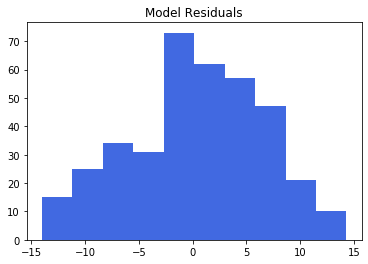

In [31]:
# Grab the residuals & then call the hist() method
(y_test - y_predict).hist(grid = False, color = 'royalblue')
plt.title("Model Residuals")
plt.show()

### Plotting our Line
We have this beautiful model, but we cannot see it. Let us create a graph where we have our data and our linear regression line on our graph. We should also highlight some of our key metrics below so we should also add them below.

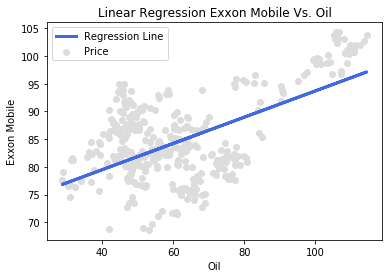

Oil coefficient:0.24
Mean squared error: 38.44
Root Mean squared error: 6.2
R2 score: 0.31


In [32]:
# Plot outputs
plt.scatter(X_test, y_test,  color='gainsboro', label = 'Price')
plt.plot(X_test, y_predict, color='royalblue', linewidth = 3, linestyle= '-',label ='Regression Line')

plt.title("Linear Regression Exxon Mobile Vs. Oil")
plt.xlabel("Oil")
plt.ylabel("Exxon Mobile")
plt.legend()
plt.show()

# The coefficients
print('Oil coefficient:' + '\033[1m' + '{:.2}''\033[0m'.format(regression_model.coef_[0][0]))

# The mean squared error
print('Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(model_mse))

# The mean squared error
print('Root Mean squared error: ' + '\033[1m' + '{:.4}''\033[0m'.format(math.sqrt(model_mse)))

# Explained variance score: 1 is perfect prediction
print('R2 score: '+ '\033[1m' + '{:.2}''\033[0m'.format(r2_score(y_test,y_predict)))

### Step Six: Save the Model for future use

We will probably want to use this model in the future, so let us save our work so we can use it later. Saving the model can be achieved by storing our model in a pickle which is storing a python object as a character stream in a file which can be reloaded later to use.

In [33]:
import pickle

# pickle the model.
with open('my_linear_regression.sav','wb') as f:
     pickle.dump(regression_model,f)

# load it back in.
with open('my_linear_regression.sav', 'rb') as pickle_file:
     regression_model_2 = pickle.load(pickle_file)

# make a new prediction.
regression_model_2.predict([[67.33]])

array([[85.94980965]])